# Task

Inputs: The power spectrum of an audio clip at a particular time.
The size of window is determined by the number of samples inside a quanta.

Outputs: An 88-dimensional vector, containing probabilities of whether or not a particular note was played.

In [3]:
import tensorflow as tf 
from tensorflow.keras import layers, models, metrics

import numpy as np 
import scipy as sp 
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

import midiio
import frequency_analysis as frqa
from midi.midi_representation import *
from musicnet_extractor import *

## Preprocessing step

In [2]:
training_data = get_data("../data/musicnet/1727.wav", "../data/musicnet/1727.csv").append(
                get_data("../data/musicnet/1759.wav", "../data/musicnet/1759.csv"))
training_data

C:\Users\JOAQUIN DELA ROSA\AppData\Local\Temp\ipykernel_21968\2350247582.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_data = get_data("../data/musicnet/1727.wav", "../data/musicnet/1727.csv").append(


,start_time,20,21,22,23,24,25,26,27,28,...,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256
0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.168419,0.168394,0.168313,0.168233,0.168235,0.168314,0.168391,0.168419,0.168409,0.168509
1,2.205047e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180148,0.180069,0.180000,0.180026,0.180155,0.180220,0.180145,0.180121,0.180248,0.180493
2,4.410095e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.170408,0.170416,0.170419,0.170419,0.170420,0.170422,0.170422,0.170422,0.170426,0.170440
3,6.615142e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.155265,0.155265,0.155266,0.155266,0.155266,0.155269,0.155271,0.155273,0.155273,0.155277
4,8.820189e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.146619,0.146619,0.146618,0.146618,0.146617,0.146618,0.146618,0.146617,0.146617,0.146619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,8.573678e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3889,8.575883e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3890,8.578089e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3891,8.580294e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Model Creation

In [4]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth 
    return tf.reduce_mean(jd)

In [7]:
inputs = np.copy(training_data[INPUT_COLUMNS])
labels = np.copy(training_data[LABEL_COLUMNS])


In [5]:
# We create a tensorflow model as follows

note_classifier = models.Sequential()

note_classifier.add(layers.Dense(200, activation=tf.nn.leaky_relu, input_shape=(257,)))
note_classifier.add(layers.Dense(200, activation=tf.nn.leaky_relu))
note_classifier.add(layers.Dense(108, activation=tf.nn.leaky_relu))
note_classifier.add(layers.Lambda(lambda x: tf.nn.sigmoid(x)))


note_classifier.compile(optimizer="adam", loss=tf.losses.binary_crossentropy)

In [8]:
note_classifier.fit(inputs, labels, batch_size=100, epochs=1000)

Epoch 1/1000
129/129 [==============================] - 2s 4ms/step - loss: 0.1283
Epoch 2/1000
129/129 [==============================] - 1s 4ms/step - loss: 0.0378
Epoch 3/1000
129/129 [==============================] - 1s 4ms/step - loss: 0.0368
Epoch 4/1000
129/129 [==============================] - 1s 4ms/step - loss: 0.0354
Epoch 5/1000
129/129 [==============================] - 1s 4ms/step - loss: 0.0336
Epoch 6/1000
129/129 [==============================] - 1s 4ms/step - loss: 0.0317
Epoch 7/1000
129/129 [==============================] - 0s 4ms/step - loss: 0.0305
Epoch 8/1000
129/129 [==============================] - 0s 4ms/step - loss: 0.0299
Epoch 9/1000
129/129 [==============================] - 0s 4ms/step - loss: 0.0295
Epoch 10/1000
129/129 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 11/1000
129/129 [==============================] - 1s 4ms/step - loss: 0.0291
Epoch 12/1000
129/129 [==============================] - 0s 4ms/step - loss: 0.0290
E

KeyboardInterrupt: 

# Model Evaluation

In [268]:
test_data = get_data('../data/musicnet/1759.wav', '../data/musicnet/1759.csv')
test_data

,start_time,20,21,22,23,24,25,26,27,28,...,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256
0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.205164e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.410328e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.615492e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.820657e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,8.573678e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3889,8.575883e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3890,8.578089e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3891,8.580294e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
test_input = np.copy(test_data[INPUT_COLUMNS])
test_labels = np.copy(test_data[LABEL_COLUMNS])
result = note_classifier.evaluate(test_input, test_labels, batch_size=64)
result

61/61 [==============================] - 0s 4ms/step - loss: 0.3870


0.38703128695487976

In [9]:
# Save the model

note_classifier.save("note_classifier.h5", )

# Unsupervised Task

In [10]:
# Load a model
classifier_model = models.load_model("note_classifier.h5", custom_objects={
    "jaccard_distance": jaccard_distance
})
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               51600     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 108)               21708     
_________________________________________________________________
lambda (Lambda)              (None, 108)               0         
Total params: 113,508
Trainable params: 113,508
Non-trainable params: 0
_________________________________________________________________


In [181]:
# Load the file
data, sample_rate = midiio.read_file("../data/song.mp3")
WINDOW_SAMPLES = sample_rate * 0.01

data = data[0] + data[1]
xs = np.linspace(0, len(data), int (len(data) / WINDOW_SAMPLES), endpoint=False)
inputs = []
for x in xs:
    f, power = frqa.get_frequencies(data[int(x) : int(x + WINDOW_SAMPLES)], sample_rate)
    inputs.append(np.abs(power))

inputs = np.array(inputs)
inputs.shape, data.shape

c:\Users\JOAQUIN DELA ROSA\anaconda3\envs\tfgpu\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


((21908, 257), (9661440,))

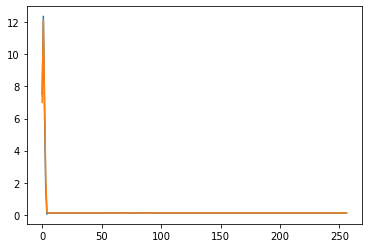

In [182]:
# Use the model to identify the notes
plt.plot(inputs[1000])
plt.plot(inputs[1010])



In [183]:
label_vector = classifier_model.predict(inputs)

In [189]:
# These determine sustain.

UPPER_THRESHOLD = 0.1
LOWER_THRESHOLD = 0.0001


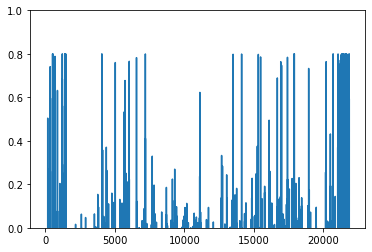

In [185]:

plt.ylim((0, 1))
plt.plot(label_vector.max(axis=1) - UPPER_THRESHOLD)


In [190]:
# Make the midi file :))

comp : Composition = Composition("Worse Apple", division=43)
comp.add_track(1, 1000)
track : Track= comp.tracks[0]

track.add_tempo_event(0, 130)
i = 0

xs = np.linspace(0, len(data), int (len(data) / WINDOW_SAMPLES), endpoint=False)
print(len(data), len(xs))

VIRTUAL_KEYBOARD = [0 for i in range(MIDI_START, MIDI_END + 1)]
for x in xs:
    note_vec = np.copy(label_vector[i])

    for y in range(MIDI_START, MIDI_END + 1):
        if note_vec[y - MIDI_START] > UPPER_THRESHOLD:
            if VIRTUAL_KEYBOARD[y - MIDI_START] == 0:
                track.add_note_on_event(int(i), 1, y, 120)
                VIRTUAL_KEYBOARD[y - MIDI_START] = 1
        elif note_vec[y - MIDI_START] < LOWER_THRESHOLD: 
            if VIRTUAL_KEYBOARD[y - MIDI_START] == 1: 
                track.add_note_off_event(int(i), 1, y)
                VIRTUAL_KEYBOARD[y - MIDI_START] = 0
    
    i = i + 1

9661440 21908


In [187]:
comp.finalize()

['0,0,Header,1,1,43',
 '1, 0, Start_track',
 '1,0,Tempo,461538',
 '1,166,Note_on_c,1,75,120',
 '1,166,Note_on_c,1,79,120',
 '1,166,Note_on_c,1,91,120',
 '1,166,Note_on_c,1,92,120',
 '1,167,Note_off_c,1,91,0',
 '1,168,Note_off_c,1,79,0',
 '1,173,Note_off_c,1,75,0',
 '1,175,Note_off_c,1,92,0',
 '1,208,Note_on_c,1,75,120',
 '1,208,Note_on_c,1,92,120',
 '1,210,Note_off_c,1,75,0',
 '1,211,Note_off_c,1,92,0',
 '1,217,Note_on_c,1,79,120',
 '1,221,Note_off_c,1,79,0',
 '1,342,Note_on_c,1,75,120',
 '1,342,Note_on_c,1,79,120',
 '1,344,Note_off_c,1,79,0',
 '1,346,Note_on_c,1,92,120',
 '1,349,Note_on_c,1,79,120',
 '1,350,Note_off_c,1,79,0',
 '1,350,Note_off_c,1,92,0',
 '1,353,Note_off_c,1,75,0',
 '1,516,Note_on_c,1,75,120',
 '1,516,Note_on_c,1,79,120',
 '1,519,Note_off_c,1,79,0',
 '1,521,Note_off_c,1,75,0',
 '1,522,Note_on_c,1,75,120',
 '1,524,Note_on_c,1,58,120',
 '1,524,Note_on_c,1,73,120',
 '1,524,Note_off_c,1,75,0',
 '1,525,Note_on_c,1,56,120',
 '1,525,Note_off_c,1,58,0',
 '1,525,Note_on_c,1,68

In [188]:
make_midi(comp)